# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [47]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

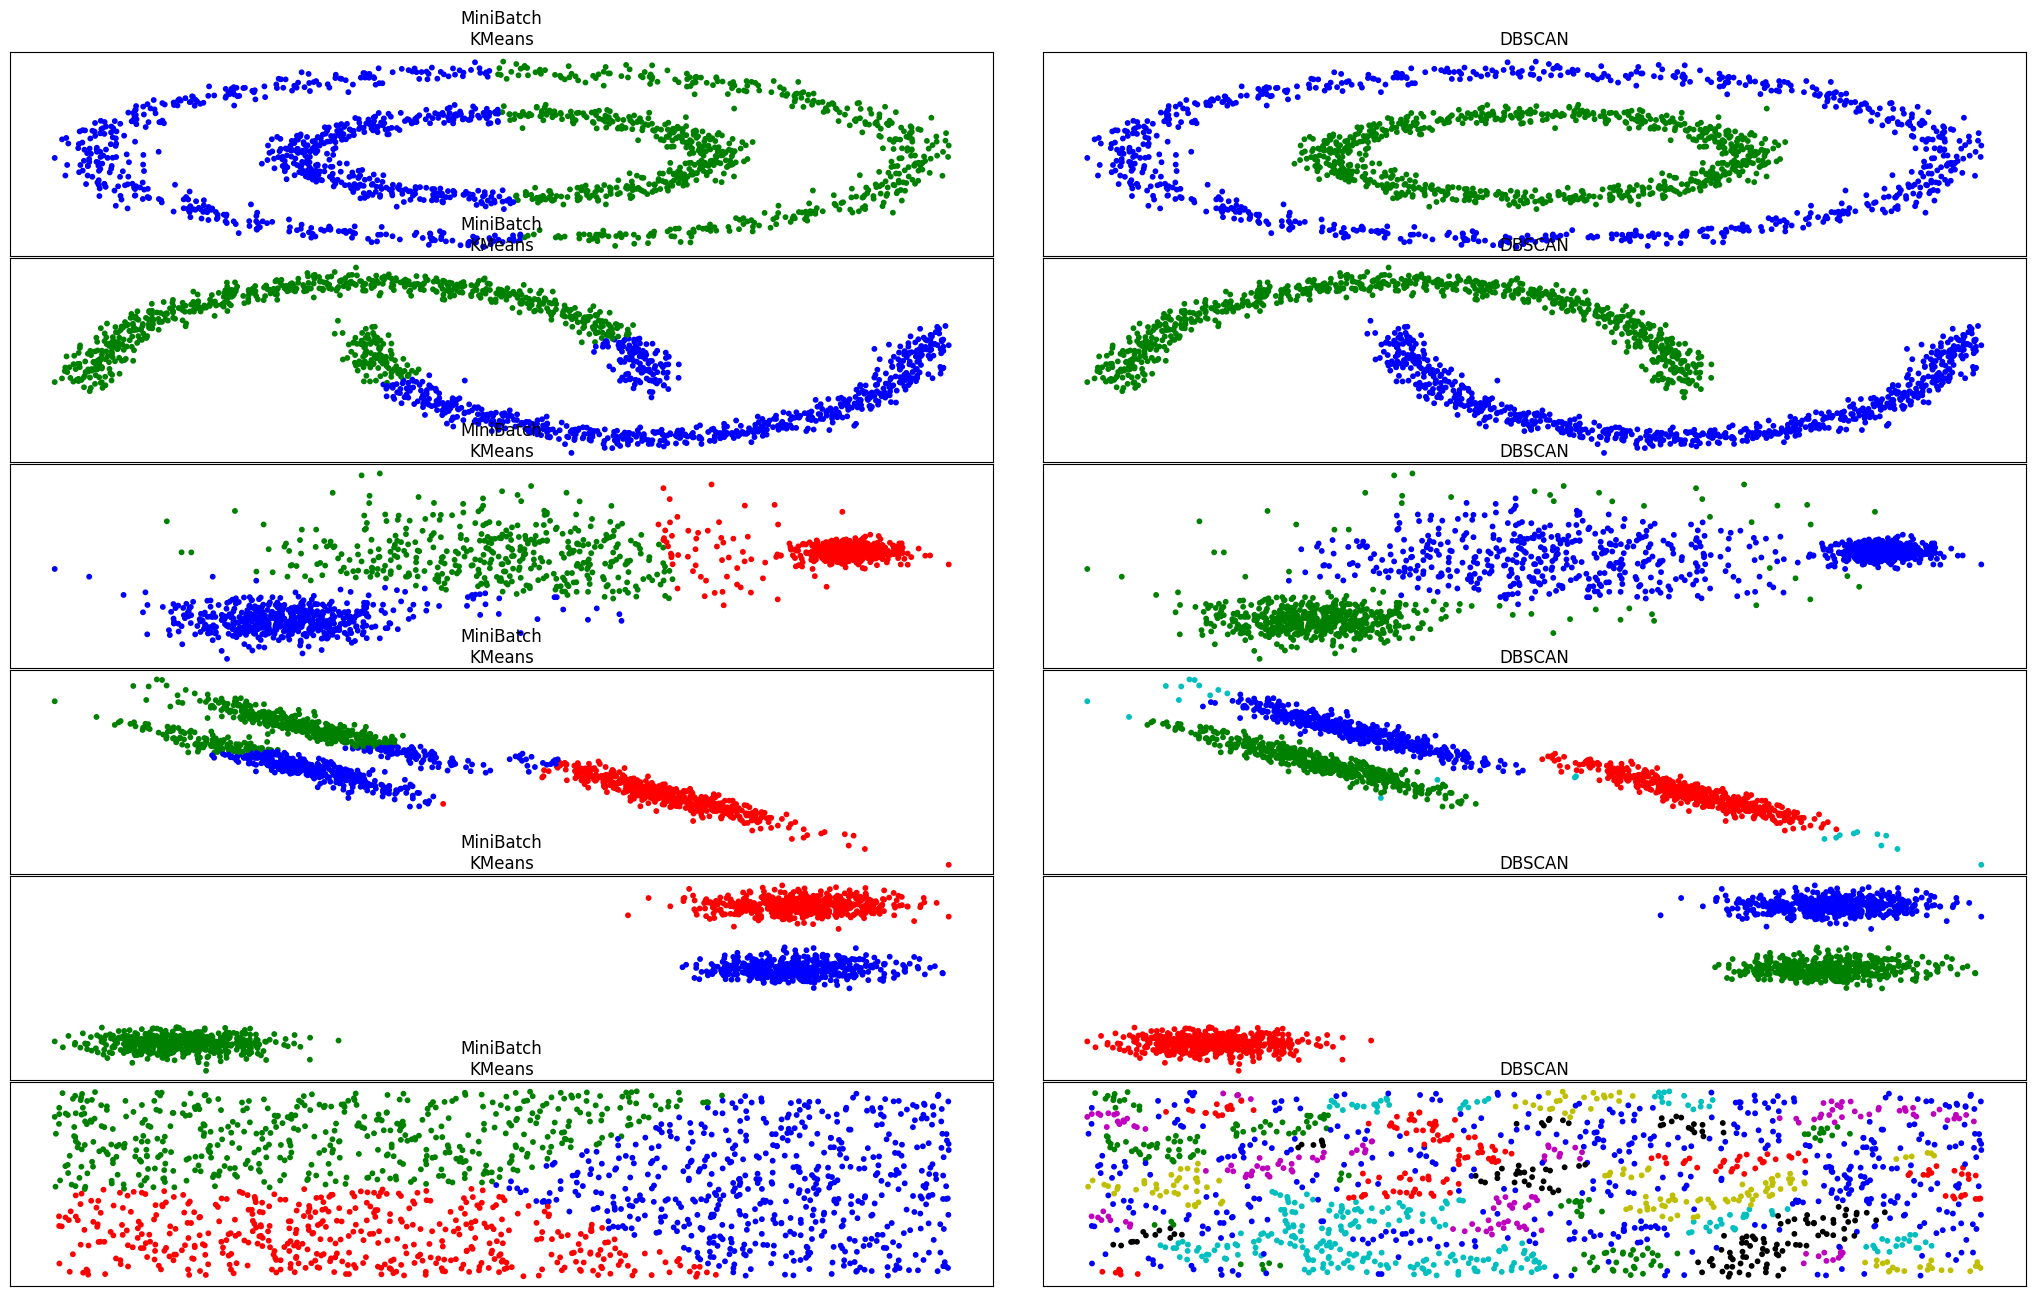

In [48]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets_list = [
    ("noisy_circles", noisy_circles),
    ("noisy_moons", noisy_moons),
    ("varied", varied),
    ("aniso", aniso),
    ("blobs", blobs),
    ("no_structure", no_structure),
]

dataset_params = {
    "noisy_circles": {"kmeans": 2, "dbscan_eps": 0.2},
    "noisy_moons": {"kmeans": 2, "dbscan_eps": 0.25},
    "varied": {"kmeans": 3, "dbscan_eps": 0.18},
    "aniso": {"kmeans": 3, "dbscan_eps": 0.15},
    "blobs": {"kmeans": 3, "dbscan_eps": 0.3},
    "no_structure": {"kmeans": 3, "dbscan_eps": 0.1},
}

for name_dataset, dataset in datasets_list:
    # update parameters with dataset-specific values
    params = default_base.copy()  # базовые параметры
    params.update(dataset_params[name_dataset])
    X, y = dataset

    two_means = cluster.MiniBatchKMeans(n_clusters=params["kmeans"])
    dbscan = cluster.DBSCAN(eps=params["dbscan_eps"], min_samples=5)
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("DBSCAN", dbscan),
    )


    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets_list), len(clustering_algorithms), plot_num)

        colors = np.array(list(islice(cycle("bgrcmyk"), int(y_pred.max() + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.title(name, size=12)
        plt.xticks([])
        plt.yticks([])

        plot_num += 1
plt.show()
